In [2]:
from collections import Counter                     # For adding together fields
import pdb                                          # For debugging
import os                                           # For filesystem management
from multiprocessing import Pool                    # For parallel execution

import numpy                                        # For faster execution times
numpy.seterr(all='raise')                           # numpy errors are treated as Python errors
from scipy.optimize import minimize_scalar          # For fitting to obtain the correlation length

import matplotlib                                   # For plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
plt.rcParams.update({"text.usetex": True})          # Plot graphs using TeX
matplotlib.rcParams['animation.writer'] = 'ffmpeg'  # The animation writer to use

In [3]:
# The following directory tells the code where to store the generated configurations
# When you change this make sure to leave a trailing backslash!
base_directory = "/mnt/drive1/Multilevel_data/"

# Make subdirectories if needed
for subdir in ['graphs', 'data', 'movies']:
    directory = f"{base_directory}{subdir}/"

    if not os.path.isdir(directory):
      os.makedirs(directory)

The following function will be used repeatedly to check if simulation data already exists.

In [4]:
def file_exists(directory, file):
    files = os.popen(f'ls {directory}')
    files = [x[:-1] for x in files]  # Remove the '\n' charachter from filenames

    return file in files

The following template functions are used to generate the filenames where data will be stored.
They are defined here so that the filenames are used consistantly throughout the code.

# Section 0: Multilevel diagram

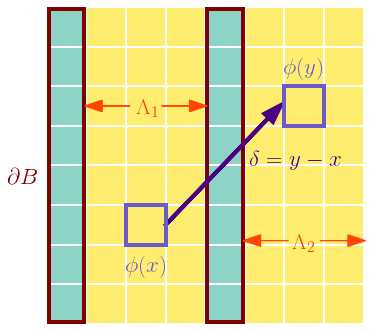

In [5]:
grid = numpy.zeros((8, 8))
grid[:, 0] = numpy.ones(8)
grid[:, 4] = numpy.ones(8)
grid = 1 - grid

plt.imshow(grid, cmap='Set3')

ax = plt.gca()
ax.grid(color='w', linestyle='-', linewidth=2)
ax.set_xticks(numpy.arange(-.5, 8, 1))
ax.set_yticks(numpy.arange(-.5, 8, 1))

for xlabel_i in ax.axes.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)

for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)

for tick in ax.axes.get_xticklines():
    tick.set_visible(False)

for tick in ax.axes.get_yticklines():
    tick.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

x = plt.Rectangle((1.5, 4.5), 1, 1, color='slateblue', lw=4, zorder=100, fill=None)
y = plt.Rectangle((5.5, 1.5), 1, 1, color='slateblue', lw=4, zorder=100, fill=None)
plt.arrow(2.5, 5, 2.6, -2.7, lw=4, color='indigo', head_width=0.3, zorder=100)
plt.text(4.6, 3.5, r'$ \delta = y - x $', color='indigo', fontsize=23)
plt.text(1.5, 6.2, r'$ \phi (x) $', color='slateblue', fontsize=23)
plt.text(5.5, 1.2, r'$ \phi (y) $', color='slateblue', fontsize=23)

B1 = plt.Rectangle((-0.45, -0.45), 0.9, 7.9, color='maroon', lw=4, zorder=80, fill=None)
B2 = plt.Rectangle((3.55, -0.45), 0.9, 7.9, color='maroon', lw=4, zorder=80, fill=None)
plt.text(-1.5, 4, r'$ \partial B $', color='maroon', fontsize=23)

plt.text(1.75, 2.2, r'$ \Lambda_1 $', color='orangered', fontsize=23)
plt.arrow(2.4, 2, 0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.arrow(1.6, 2, -0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.text(5.7, 5.6, r'$ \Lambda_2 $', color='orangered', fontsize=23)
plt.arrow(6.4, 5.4, 0.7, 0, color='orangered', zorder=100, head_width=0.3)
plt.arrow(5.6, 5.4, -0.7, 0, color='orangered', zorder=100, head_width=0.3)

ax.add_patch(x)
ax.add_patch(y)
ax.add_patch(B1)
ax.add_patch(B2)

fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.savefig(f'{base_directory}graphs/multilevel_diagram.pdf')

plt.show()

In [6]:
def template_1_1(L, beta, N, step):
    return f"ising_spins_1_1_L{L}_b{beta:.10f}_N{N}_step{step}.npy"
  
def template_splitting(L, beta, N, M, step, i, j):
    return f"L{L}_b{beta:.10f}_N{N}_M{M}_step{step}_spins_{i}_{j}.npy"

def template_twopt(L, beta, N, step, delta):
    return f"twopt_single_slice_L{L}_beta{beta}_N{N}_step{step}_delta{delta}.npy"

def template_twopt_bootstrap(L, beta, N, step, delta, no_samples):
    return f"twopt_single_slice_boot_L{L}_beta{beta}_N{N}_step{step}_delta{delta}" + \
            f"_no_samples{no_samples}.npy"

def template_twopt_multi(L, beta, N, delta, M, step, splitting):
    return f"twopt_multi_slice_L{L}_beta{beta}_N{N}_M{M}_step{step}_delta{delta}_sp{splitting}.npy"

def template_twopt_multi_weighted(L, beta, N, M, step, delta, no_samples, weights, bin_size):
    return f"twopt_weighted_multi_slice_L{L}_beta{beta}_N{N}_M{M}_step{step}_delta{delta}_" + \
            f"no_samples{no_samples}_weights{weights}_bin_size{bin_size}.npy"

def template_twopt_calculation(beta, L, N, M, no_samples, step, bin_size):
    return f"results_run_N{N}_M{M}_L{L}_step{step}" + \
           f"_beta{beta}_no_samples{no_samples}_binsize{bin_size}.npy"

# 1. The Ising Model
## 1.1. Utility Functions
In order to perform multilevel, we must label the subregions of the lattice. region_maker() is a generalized function that takes the sidelength of the lattice, L, and a tuple of the splitting, s, as inputs. Each element of s is the number of sublattices along a given direction, e.g. the s[0]=2 means that along the x-axis the lattice is split into 2. The number of dimensions is inferred by the lenghth of s. The boundary layers seperating the sub-lattices are labelled by 0, while the subregions are numbered 1, 2, ... . For example, region_maker(8, (2, )) returns $[0, 1, 1, 1, 0, 2, 2, 2]$.

In [7]:
def region_maker(L, s):
    """
        This function will return an array of the same shape as the lattice, called regions. This
        array uniquely labels all regions of the lattice, and labels the boundaries by 0.

        INPUTS:
        -------
        L : int, size of the lattice (Assumed to be the same size in all directions currently.)
        s : (n, ) tuple of ints, describing how the lattice is to be broken
            down in the directions (x1, ..., xn). The dimensionality of the lattice is inferred
            from the length of s
        
        OUTPUTS:
        --------
        (L, ) * len(s) numpy array of ints. The integers represent the sub-lattice identity of
            each point on the lattice.
    """
    for i in s:
        assert type(i) == int, "The lattice must be divided into an integer number of subregions"
        assert i >= 1, "Components of s must be greater of equal to 1"
        assert L % i == 0, "The lattice size must divide exactly into the number of subregions"

    s = numpy.array(s, dtype=int)
    dim = len(s)
    shape = (L, ) * dim

    # The trivial case where there is no splitting of the lattice, simply label all sites as 1
    if numpy.product(numpy.array(s)) == 1:
        return numpy.ones(shape)

    regions = numpy.zeros(shape)
    indices = numpy.indices(shape).reshape(dim, L ** dim).T

    for i in range(len(indices)):
        x = indices[i]
        total = 0

        # Labels the subregion indices of this position
        R = x // (L // s)

        # 0 if on boundary, 1 if not
        B = numpy.product(numpy.where(s > 1,
                                      numpy.where(x % (L // s), 1, 0),
                                      1))

        for i in range(dim):
            total *= s[i]
            total += (R[i] + (i + 1) // dim) * B

        regions[tuple(x)] = total

    return regions

As an example the sub-regions of a two-dimensional lattice split into four quadrants is accessed by region_maker(8, (2, 2))

In [8]:
print(region_maker(8, (2, 2)))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 2. 2. 2.]
 [0. 1. 1. 1. 0. 2. 2. 2.]
 [0. 1. 1. 1. 0. 2. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 3. 3. 0. 4. 4. 4.]
 [0. 3. 3. 3. 0. 4. 4. 4.]
 [0. 3. 3. 3. 0. 4. 4. 4.]]


In order to visualize multilevel in the Ising model we need to plot the lattice of spins. The spin array elements will take values of +1 for spin up, and -1 for spin down. This function takes a matplotlib axis as input (for the purpose of making movies later), as well as an array of spins.

In [9]:
def plot_spins(spins, ax=None):
    """
        This function plots a lattice of spins, with spin up taking a purple color and spin down
        a green color. It takes an existing matplotlib axis as input for the purpose of making
        movies.

        INPUTS:
        -------
        spins: numpy array of integers or floats. Values assumed to be either -1 or +1

        ax: matplotlib axis object

        OUTPUTS:
        --------
        Instance of matplotlib.image.AxesImage class
    """
    if ax is None:
        fig, ax = plt.subplots()

    L = spins.shape[0]

    # create discrete colormap
    cmap = colors.ListedColormap(['mediumspringgreen', 'darkturquoise', 'slateblue', 'mediumorchid'])
    bounds = [-2, -0.9, 0, 0.9, 2]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    Imshow_axes = ax.imshow(spins, cmap=cmap, norm=norm)
    ax.grid(color='w', linestyle='-', linewidth=2)
    ax.set_xticks(numpy.arange(-.5, L, 1))
    ax.set_yticks(numpy.arange(-.5, L, 1))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for xlabel_i in ax.axes.get_xticklabels():
        xlabel_i.set_visible(False)
        xlabel_i.set_fontsize(0.0)

    for xlabel_i in ax.axes.get_yticklabels():
        xlabel_i.set_fontsize(0.0)
        xlabel_i.set_visible(False)

    for tick in ax.axes.get_xticklines():
        tick.set_visible(False)

    for tick in ax.axes.get_yticklines():
        tick.set_visible(False)
    
    return Imshow_axes

To check this works let's create a random lattice of spins

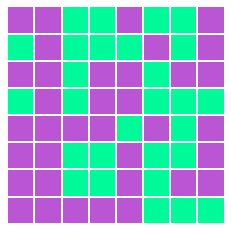

In [10]:
# Create an empty figure
fig, ax = plt.subplots()

# Plot the random spin arrangement
spin_test = numpy.random.randint(2, size=(8, 8)) * 2 - 1
plot_spins(spin_test, ax)
plt.show()

For the purpose of parrallelisation of the Metropolis-Hastings algorithm, the following function constructs a chessboard pattern over a lattice. This is only possible on lattices with even side lengths, because of periodic boundary conditions. This function is written for two-dimensions though it could be extended to higher dimensions easily.

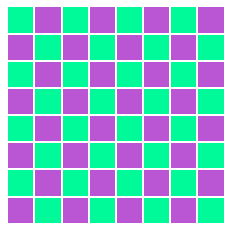

In [11]:
def chessboard_2D(L):
    """
        This function creates a two-dimensional chessboard pattern for the purpose of vectorising
        the Metropolis-Hastings algorithm.

        INPUTS:
        -------
        L: Even integer, lattice side-length

        OUTPUTS:
        --------
        (L, L) numpy array of ints
    """
    assert type(L) == int, "The lattice should have an integer number sidelength"
    assert L%2 == 0, "L should be even"

    board = numpy.zeros((L, L), dtype=int)

    for i in range(L):
        for j in range(L):
            board[i, j] = (i + j) % 2

    return board

# Plot an example 8 x 8 chessboard
fig, ax = plt.subplots()
plot_spins(chessboard_2D(8) * 2 - 1, ax)
plt.show()

In the Ising model the energy is given by
$H = -J \sum_{i, j \: (n.n.)}s_is_j - B\sum_i s_i$, where n.n. stands for nearest neighbours. We are therefore compelled to have an easy way to calculate the sum of the spins of nearest neighbours to a point. We will take $J = 1$, $B = 0$ throughout this project.

In [12]:
def neighbour_total(spin_array):
    """
        This function takes an array of spins, and returns, at each position in
        the lattice, the total of the neighbouring spins to that lattice position.

        INPUTS :
        --------
        spin_array: numpy array object with entries of either 1 or (-1)

        OUTPUTS :
        ---------
        total_neighbour_spin: a numpy array of the same shape and type as the spin_array
    """
    total_neighbour_spin = numpy.zeros(spin_array.shape)

    for dim in range(len(spin_array.shape)):
        total_neighbour_spin += numpy.roll(spin_array, 1, axis=dim)
        total_neighbour_spin += numpy.roll(spin_array, -1, axis=dim)

    return total_neighbour_spin

## 1. 2. Generating Configurations
Configurations are generated by performing steps of the Metropolis-Hastings algorithm on a lattice of spins. We either initise a random assorment of spins or initize the class with a pre-existing array of spins.

In [13]:
class lattice(object):
    def __init__(self, L, splitting, beta=1, spins=None):
        """
            INPUTS :
            --------
            L: even int, sidelength of lattice

            splitting: tuple of ints, the number of sublattices in each dimension

            beta: float, the inverse temperature
            
            spins: (L, L) numpy array with either -1 or +1 at each entry. This is a starting
                configuration of spins. If None then the starting configuration of spins will be
                generated randomly
        """
        if spins is None:
            spins = numpy.random.randint(0, 2, size=(L, L)) * 2 - 1

        else:
            self.spins = spins

        self.spins = numpy.array(spins, dtype=numpy.int8) # For reduced memory / harddrive usage
        self.chessboard = chessboard_2D(L)
        self.regions = region_maker(L, splitting)
        self.beta = beta
        self.L = L

        # This is the total energy associated with all interactions at a point - to get the correct
        # total energy density this value should be halved, since interactions involve two sites.
        self.energies = -self.spins * neighbour_total(self.spins)

    def step(self):
        """
            This function performs one step of the Metropolis-Hastings algorithm, updating the
            spins and energies.
        """
        ## Flip the white squares  (of the "chessboard") first

        # The amount the energy will change if the spin flips
        delta_E = -self.energies * 2  
        
        # Using the metropolis algorithm
        jump_condition = numpy.exp(-self.beta * delta_E) > numpy.random.rand(self.L, self.L)

        # Flip a site if
        # 1. It passes the Metropolis-Hastings flip condition
        # 2. The site isn't on the boundary
        # 3. It is one of the squares on the chessboard being flipped
        to_flip = numpy.logical_and(jump_condition,
                                    numpy.logical_and(self.regions, self.chessboard))

        self.spins = numpy.where(to_flip, -self.spins, self.spins)
        
        # Recalculate all site energies
        self.energies = -self.spins * neighbour_total(self.spins)

        ## Now flip the black squares
        delta_E = -self.energies * 2
        jump_condition = numpy.exp(-self.beta * delta_E) > numpy.random.rand(self.L, self.L)

        to_flip = numpy.logical_and(jump_condition,
                                    numpy.logical_and(self.regions,
                                                      numpy.logical_not(self.chessboard)))

        self.spins = numpy.where(to_flip, -self.spins, self.spins)
        self.energies = -self.spins * neighbour_total(self.spins)

The following function generates $N$ configurations of the two-dimensional Ising model with a single level algorithm. It is named with '1_1', because you can think of a lattice with no subdivisions as being constructed from 1x1 sublattices.

In [14]:
def generate_states_1_1(L, beta, N, step, rerun=False):
    """
        INPUTS :
        --------
        L: int, sidelength of lattice

        beta: float, the inverse temperature

        N: int, number of configurations to save in the ensemble

        step: int, number of update steps between configurations

        rerun: bool, if True then rerun the generation even if a saved file with this ensemble is
            found
            
        OUTPUTS :
        ---------
        (N, L, L) numpy array of ints representing N spin configurations of size (L, L)
    """
    # Save file location
    filename = template_1_1(L, beta, N, step)
    directory = f"{base_directory}data/"

    # If the saved data is found, and rerun is False then load the data
    if (not rerun) and file_exists(directory, filename):
        return numpy.load(f"{directory}{filename}")
  
    print(f"Generating states for : L = {L}, N = {N}, beta = {beta:.10f}, splitting = (1, 1)")

    data = numpy.zeros((N, L, L), dtype=numpy.int8)

    x = lattice(L, (1, 1), beta=beta)

    # Use 50 * step for the number of thermalization steps
    initial = step * 50

    # Perform the init equillibriating steps of the Monte Carlo
    for j in range(initial):
        x.step()

    # Now start recording configurations
    for i in range((N - 1) * step + 1):
        if(i % step == 0):
            data[i // step] = x.spins

        x.step()

    numpy.save(f"{directory}{filename}", data)

    return data

To generate ensembles with a split lattice the technique is very similar except for each of the N "higher-level" configurations, the configurations of the boundary spins are taken, and M multilevel states are produced from there.

In [15]:
def generate_states_splitting(L, beta, N, M, step, splitting, rerun=False):
    """
        INPUTS :
        --------
        L: int, size length

        beta: float, inverse temperature

        N: int, number of boundary configurations

        M: int, number of sublattice configurations per boundary

        step: int, number of update steps between sublattice configurations

        splitting: (2, ) tuple of ints giving the number of sublattices in each direction
        
        OUTPUTS :
        ---------
        (N, M, L, L) numpy array of {-1, 1} representing the spin configurations
    """
    i, j = splitting[0], splitting[1]

    directory = f"{base_directory}data/"
    filename = template_splitting(L, beta, N, M, step, i, j)

    # This is the file of single level data used to construct multilevel data
    source_file = template_1_1(L, beta, N, step)
    
    # If the saved data is found, and rerun is False then load the data
    if (not rerun) and file_exists(directory, filename):
        return numpy.load(f"{directory}{filename}")

    data = numpy.zeros((N, M, L, L), dtype=numpy.int8)
    
    # Check if the source file exists
    if not file_exists(directory, source_file):
        print("No source configuration files - generating these first")
        generate_states_1_1(L, beta, N, step, rerun=rerun)

    elif rerun:
        print("Rerunning source configurations")
        generate_states_1_1(L, beta, N, step, rerun=rerun)

    # Load in N configurations from source file
    source_data = numpy.load(f"{directory}{source_file}")[0: N]

    print(f"Generating states for : L = {L}, N = {N}, M = {M}, beta = {beta:.10f}, splitting = ({i}, {j})")

    for k in range(N):
        # Use the spin configurations from the single level data as starting points
        x = lattice(L, splitting, beta=beta, spins=source_data[k])

        for l in range((M - 1) * step + 1):
            if l % step == 0:
                data[k, l // step] = x.spins

            x.step()

    numpy.save(f"{directory}{filename}", data)

    return data

## 1. 3. Visualization
To check that the system is behaving as expected, the following movie function that will iterate through some of this multilevel data, showing the evolution of the spin array.

In [16]:
def animate(lattice_data, dt=0.1):
    """
        INPUTS :
        --------
        lattice_data: (N, L, L) or (N, M, L, L) numpy array of {-1, 1} - single level or multilevel
            spin data.

        dt: float, change in time between frames

        RETURNS :
        ---------
        ani : Instance of matplotlib.animation.FuncAnimation class
    """
    # True for multilevel and single level
    L = lattice_data.shape[2]

    #  If the data is multilevel, we want to change the array shape to (N * M, L, L) first
    if len(lattice_data.shape) == 4:
        multi = True

        # Number of frames equals number of configs/subconfigs
        no_iterations = lattice_data.shape[0] * lattice_data.shape[1]

        lattice_data = lattice_data.reshape((lattice_data.shape[0] * lattice_data.shape[1], L, L))

    else:
        multi = False
        no_iterations = lattice_data.shape[0]

    # Create figure and axis
    fig = plt.figure()
    ax = plt.gca()

    # Setting the axes properties
    ax.set_xlim([-0.5, L - 0.5])
    ax.set_ylim([-0.5, L - 0.5])

    #  In order to highlight the bounary sites
    if multi:
        lattice_data = lattice_data.astype(float)
        lattice_data[:, 0, :] *= 0.5
        lattice_data[:, L // 2, :] *= 0.5
        lattice_data[:, :, 0] *= 0.5
        lattice_data[:, :, L // 2] *= 0.5

    plot_me = plot_spins(lattice_data[0], ax)

    def update(num):
        data = lattice_data[num]
        plot_me.set_data(data)
        return plot_me,

    # Creating the Animation object
    ani = FuncAnimation(fig, update, frames=range(no_iterations), interval=int(dt * 1000),
                        blit=True, repeat=False)

    return ani

High temperature single level. The boundary layers are highlighted, however, for a single level algorithm they are equivalent to non-boundary sites. They are shown for easy comparison to the later multilevel example.

KeyboardInterrupt: 

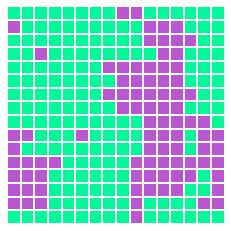

In [17]:
L = 16
beta = 0.4
N = 100
step = 1

data = generate_states_1_1(L, beta, N, step, rerun=False)

anim = animate(data)

directory = f'{base_directory}movies/'
filename = 'single_level_spin_movie.gif'

# GIF type animation saved to file
anim.save(f'{directory}{filename}', dpi=500)

And now let us study the effects of the boundary. In the following video, N=10 and M=10, so there are 10 boundary configurations and 10 sublattice updates per boundary. I will use the previous configurations as a source of boundary configurations.

KeyboardInterrupt: 

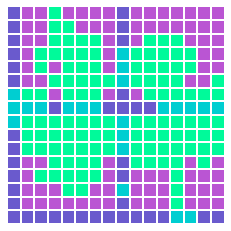

In [18]:
N = 10
M = 10
L = 16
step = 1
beta = 0.4

data = generate_states_splitting(L, beta, N, M, step, (2, 2))

anim = animate(data)

directory = f'{base_directory}movies/'
filename = 'multi_level_spin_movie.gif'

# GIF type animation saved to file
anim.save(f'{directory}{filename}', dpi=500)

Note that for a smoother animation a step size of 1 was used. However, because of autocorrelations it is often necessary to use a larger step size. I found in this project that a step size of 20 gave acceptable results.

## 2.1. Implementing slice classes
### 2.1.1 Single Level

In [19]:
class single_slice_ising:
    def __init__(self, L, beta, N, step, rerun=False):
        """
            INPUTS :
            --------
            L: int, side length of the lattice

            beta: float, inverse temperature

            N: int,number of configurations

            step: int, number of update steps between configurations

            rerun: bool, if True then source files will be regenerated regardless of whether save
                files are found
        """
        # Generate or load in relevent configuration
        self.spins = generate_states_1_1(L, beta, N, step, rerun=rerun)

        # Average over one of the spatial dimensions of the lattice
        self.spin_slice = numpy.mean(self.spins, axis=2)

        self.beta = beta
        self.L = L
        self.N = N
        self.step = step

    def twopt(self, delta, rerun=False):
        """
            Function that calculates the value of the two-point function with a seperation of delta
            
            INPUTS :
            --------
            delta: int, seperation distance between slices
            
            RETURNS :
            ---------
            (N, L) numpy array of floats
        """
        # As algorithm is deterministic, then one can choose to load the results from a save file
        directory = f"{base_directory}data/"
        filename = template_twopt(self.L, self.beta, self.N, self.step, delta)

        # Check if the data already exists (only if rerun is False)
        if (not rerun) and file_exists(directory, filename):
            return numpy.load(f"{directory}{filename}")

        twopt = self.spin_slice * numpy.roll(self.spin_slice, -delta, axis=1)

        numpy.save(f"{directory}{filename}", twopt)

        return twopt

    def twopt_bootstrap(self, delta, no_samples, seed=0, rerun=False):
        """
            This function performs a bootstrap over samples of the configurations and calculates
            the two-point function of the samples.

            INPUTS:
            -------
            delta: int, seperation distance between slices

            no_samples: int, number of bootstrap samples

            RETURNS:
            --------
            (no_samples, ) array of floats
        """
        # As algorithm is deterministic, then one can choose to load the results from a save file
        directory = f"{base_directory}data/"
        filename = template_twopt_bootstrap(self.L, self.beta, self.N, self.step, delta, no_samples)

        # Check if the data already exists (only if rerun is False)
        if (not rerun) and file_exists(directory, filename):
            return numpy.load(f"{directory}{filename}")

        numpy.random.seed(seed)

        # Load in the twopt calculations
        twopt = numpy.mean(self.twopt(delta, rerun=rerun), axis=1)

        # Perform a bootstrap
        bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))
        result = numpy.zeros(no_samples)

        for i in range(no_samples):
            result[i] = numpy.mean(twopt[bootstrap[i]])

        numpy.save(f"{directory}{filename}", result)

        return result

### 2.1.2. Multilevel

Before we get the full class defintion we need the following accessary function. This is a first pass attempt to find the weighting scheme we should use when constructing weighted averages in a multilevel scheme. Correlators between two boundaries have a weight of $1$, while correlators between a boundary and a non-boundary site, or between two sites in the same sub-lattice, have a weight of $M$. Correlators between two different sub-lattices have a weight of $M^2$. These weights are then normalized by $\sum_x W^m_x = 1$

In [21]:
def basic_weights(L, splitting, delta, M):
    """
        This function performs the basic weighting scheme where
        > boundary-boundary correlators are weighted at 1
        > boundary-sub-lattice and correlators within the same sub-lattice are weighted at M
        > correlators between different sub-lattices are weighted at M^2

        INPUTS :
        --------
        L : int, sidelength of the lattice
        splitting : int, number of sublattices in the remaining dimension after slice-averaging
        delta : the displacement along the slice direction
        M : int, Number of sublattice updates per boundary update
        
        RETURNS :
        ---------
        (L / splitting, ) numpy array of float/int
    """
    # Set all the weights to M
    xweights = numpy.ones(L) * M

    # Set boundaries to 1
    xweights[::L // splitting] = 1

    # Roll to get calculate weights at second point, y
    yweights = numpy.roll(xweights, -delta)

    # Calculate the regions
    xregions = region_maker(L, (splitting, ))

    # roll this to get regions for second point
    yregions = numpy.roll(xregions, -delta)

    # Use this to determine weights
    weights = numpy.where(xregions != yregions, xweights * yweights, xweights)

    return weights[:L//splitting]

Let's look at an example: An L = 12 lattice, divided into two. Let's first consider a two-point function of $\delta = 6$. This means that all contributions, except those of the boundary, benefit from multilevel, and so get an M^2 weight, while the boundary has a weight of 1.

Note also that there are only 6 values given in the output. This is because the lattice is translationally invariant under a shift of the size of the sublattice, so the weights associated with x in {0, 5} are the same as those with x in {6, 11}

In [22]:
basic_weights(12, 2, 6, 10)

array([  1., 100., 100., 100., 100., 100.])

Now consider a two-point seperation of 2, meaning that only two-point functions involving lattice sites directly adjacent to the boundary will benefit from multilevel.

In [23]:
basic_weights(12, 2, 2, 10)

array([ 10.,  10.,  10.,  10.,  10., 100.])

To get the optimum weights, we will need some maths. A priori, all of the two-point estimators at each slice coordinate are random variables with a mean given by the true lattice value of the twopt function and some variance. All of these variances/covariances together form a covariance matrix, COV. By averaging over the N boundary configurations and assuming that the central limit theorum holds, then the two-point estimators are individually of the form $N\left(C_2(\delta), \frac{\sigma^2}{N}\right)$. When we make a weighted average of these estimators, with weight vector $\textbf{w}$, we get a general result of $N\left(C_2(\delta), \frac{\textbf{w}\cdot COV \cdot \textbf{w}}{N}\right)$.

We therefore get the minimization problem of minimizing $\textbf{w}\cdot COV \cdot \textbf{w}$ with respect to $\textbf{w}$, while maintaining $\sum_x{w(x)} = 1$. This has the solution

$W_y = \frac{\sum_x Cov_{xy}^{-1}}{\sum_{x y} Cov_{xy}^{-1}}$

In [24]:
def get_weights(cov_matrix):
    """
        This function calculates the optimum weights for multilevel correlators given a covariance
        matrix of the correlator values.

        INPUTS:
        -------
        cov_matrix: (L // splitting, L // splitting) numpy array of floats, where L is the lattice
            size and splitting is the number of sub-lattices the lattice is divided into in the
            dimension perpendicular to the slice coordinates

        RETURNS:
        --------
        (L // splitting, ) numpy array of floats
    """
    # Invert the matrix and use this to caclulate the weights
    cov_inv = numpy.linalg.inv(cov_matrix)
    weights_vector = numpy.sum(cov_inv, axis=1)

    # Normalieze the weights
    weights_vector = weights_vector / numpy.sum(weights_vector)

    return weights_vector

We are now ready to make the multilevel slice class.

In [25]:
class multi_slice_ising:
    def __init__(self, L, beta, N, M, splitting=2, step=100, rerun=False):
        """
            INPUTS:
            -------
            L: int, side length of the lattice

            beta: float, inverse temperature

            N: int, number of boundary configurations

            M: int, number of sub-lattice configurations

            step: int, number of update steps between configurations

            splitting: int, number of sub-lattices the lattice is divided into in the dimension
                perpendicular to the slice coordinates

            rerun: bool, if True then source files will be regenerated regardless of whether save
                files are found
        """
        self.spins = generate_states_splitting(L, beta, N, M, step, (splitting, 1), rerun=rerun)
        self.spin_slice = numpy.mean(self.spins, axis=3)
        self.beta = beta
        self.L = L
        self.N = N
        self.step = step
        self.M = M
        self.regions = region_maker(L, (splitting, ))
        self.splitting = splitting

    def twopt(self, delta, rerun=False):
        """
            Calculate the two-point function between slice coordinates with a seperation of delta.

            INPUTS:
            -------
            delta: int, seperation between slices in the two-point function

            RETURNS:
            --------
            (N, L) numpy array of floats
        """
        directory = f"{base_directory}data/"
        filename = template_twopt_multi(self.L, self.beta, self.N, delta, self.M, self.step,
                                        self.splitting)

        if (not rerun) and file_exists(directory, filename):
            return numpy.load(f"{directory}{filename}")
        
        # Calculate the twopt function for each value of N first
        x_slice = self.spin_slice
        regions = self.regions

        y_slice = numpy.roll(x_slice, -delta, axis=2)
        y_regions = numpy.roll(regions, -delta)

        # Multilevel product
        combinatoric_av = numpy.zeros((self.N, self.L))
        for i in range(self.M):
            for j in range(self.M):
                combinatoric_av += x_slice[:, i, :] * y_slice[:, j, :] / (self.M) ** 2
        
        # For twopt correlators where multilevel isn't valid
        within_region = x_slice * y_slice

        # Average over sublattice configurations
        within_region_av = numpy.mean(within_region, axis=1)

        # Perform a multilevel product where applicable (two sites in different subregions)
        twopt = numpy.where(regions != y_regions, combinatoric_av, within_region_av)

        numpy.save(f"{directory}{filename}", twopt)

        return twopt

    def twopt_weighted(self, delta, no_samples, weights="optimized", bin_size=1, seed=0, rerun=False):
        """
            This calculates an estimate of the two-point function, taking a weighted average over
            the different locations in the lattice that contribute to the two-point function

            INPUTS:
            -------
            delta: int, seperation between slices in the two-point function

            no_samples: int, number of bootstrap samples

            weights: string, one of three options:
                > 'optimized': Choose the weighting scheme that gives the minimum standard
                    deviation by calling the function get_weights()
                > 'basic': Use the basic weighting scheme with a call to the basic_weights()
                    function
                > 'even': All contributions are weighted equally

            bin_size: int, the size of the bins used for seperating the data when calculating
                weights. Only relevent for the weights='optimized'

            seed: int, the seed used for random number generation

            RETURNS:
            (no_samples, ) numpy array of floats
        """
        directory = f"{base_directory}data/"
        filename = template_twopt_multi_weighted(self.L, self.beta, self.N, self.M, self.step,
                                                 delta, no_samples, weights, bin_size)

        if (not rerun) and file_exists(directory, filename):
            return numpy.load(f"{directory}{filename}")

        numpy.random.seed(seed)

        # Calculate bootstrap samples for each set
        bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))
        result = numpy.zeros(no_samples)

        # Load in the twopt calculations
        twopt = self.twopt(delta, rerun=rerun)
        twopt = twopt.reshape(self.N, self.splitting, self.L // self.splitting)
        twopt = numpy.mean(twopt, axis=1)

        for i in range(no_samples):
            # Randomly shuffle the configurations
            twopt_sample = twopt[bootstrap[i]]

            if weights == 'optimized':
                # Number of bins used for caclulation of the weights
                assert self.N % bin_size == 0, "The bin number must exactly divide N"
                no_bins = self.N // bin_size

                for j in range(no_bins):
                    # Extract all data except one bin, and seperately just that bin
                    twopt_rest = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size != j]
                    twopt_bin = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size == j]

                    # Caclulate the covariance matrix
                    cov_matrix = numpy.cov(twopt_rest, rowvar=False)

                    weights_vector = get_weights(cov_matrix)

                    # Use the weights of one group to find the average of another
                    result[i] += numpy.mean(numpy.average(twopt_bin, weights=weights_vector,
                                                          axis=1)) / no_bins

            if weights == 'basic':
                weights_vector = basic_weights(self.L, self.splitting, delta, self.M)

                result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights_vector, axis=1))

            if weights == 'equal':
                weights_vector = numpy.ones(self.L // self.splitting)

                result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights_vector, axis=1))

        numpy.save(f"{directory}{filename}", result)
        
        return result

While all estimators of the two-point function have the same mean, they have varying variance and covariance relative to eachother. To define this we first average the two-point function over the M^2 subconfigurations produced by multilevel, to get N values for each slice coordinate (N x L overall). We can then consider the L x L empirical covariance matrix of this data.

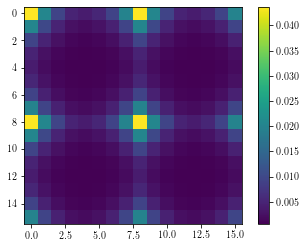

In [ ]:
N = 50
M = 50
L = 16
delta = L // 2
beta = 0.35

data = multi_slice_ising(L, beta, N, M, 2)

# Calculate the twopt function between points seperated by half the lattice size
twopt_data = data.twopt(delta)

cov_matrix = numpy.cov(twopt_data, rowvar=False)

plt.imshow(cov_matrix)
plt.colorbar()
plt.savefig(f"graphs/cov_matrix_N{N}_M{M}_L{L}_delta{delta}.pdf")
plt.show()

Note that delta is L / 2, so there is a contribution between the two boundaries (as they are half the lattice size apart), which has high variance, as there is no new samples of this as the sub-lattices are simulated. The boundaries are located at positions 0 and 8, and so (0, 0) in the above is the variance of the first boundary correlator to the second. Similarly with (8, 8).

The variance and covariance of points closer to the boundary are higher than those further from the boundary, because these points are influenced by the boundary and therefore vary less when we simulate the sub-lattices.

The algorithm is symmetric in exchange of the two sublattices. We can simplify the covariance using this fact by averaging over the subregions. This is equivalant to taking the top-left corner of the covariance matrix calculated above (or any of the quadrants).

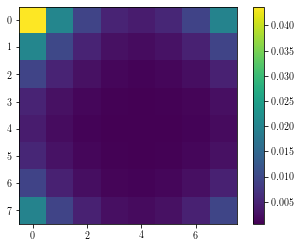

In [26]:
twopt_data = ((twopt_data + numpy.roll(twopt_data, -L//2, axis=1))/2)[:, :L//2]

cov_matrix = numpy.cov(twopt_data, rowvar=False)

plt.imshow(cov_matrix)
plt.colorbar()
plt.show()

### 2.2. Numerical Results

We're now in a position to study the relative performance of single level vs. multilevel algorithms. We wish to look at the dependence of the performance on the correlation length. So we will use the following function to extract the correlation length from the two-point functions.

In [47]:
def cosh_fit_xi_only(twopt_data, L):
    # Calculate the covarience matrix
    cov = numpy.cov(twopt_data, rowvar=True)

    # Invert the covarience matrix
    cov_inv = numpy.linalg.inv(cov)

    # Prepare the data for the fitted
    y_s = numpy.mean(twopt_data, axis=1)
    x_s = numpy.arange(0, L // 2 + 1)

    # The expected functional form of the two-point correlator
    def f(xi, x, y0):
        A = y0 / (1 + numpy.exp(-L / xi))
        return A * (numpy.exp(-x / xi) + numpy.exp(-(L - x) / xi))

    # Define the residuals function
    def chisq(xi):
        unnormalized = y_s - f(xi, x_s, y_s[0])
        return numpy.dot(unnormalized, numpy.dot(cov_inv, unnormalized))

    # Minimize this function
    res = minimize_scalar(chisq, bounds=[0, L], method='bounded')

    xi = res.x

    A = y_s[0] / (1 + numpy.exp(-L / xi))

    return xi, A

To do this study we need to find the perfomance and correlation length over a range of $\beta$ (inverse temperature).

In [26]:
def run_twopt_calculations(beta, N, M, L, no_samples=100, step=20, bin_size=10, rerun=False,
                           seed=0, seed_single=0, seed_multi=0):
    """
        This is a utility function which is used for the data generation of the numerical results
        in this project.

        INPUTS:
        -------
        beta: float, inverse temperature

        L: int, side length of the lattice

        N: int, number of boundary configurations

        M: int, number of sub-lattice configurations

        no_samples: int, number of bootstrap samples

        step: int, number of update steps between configurations

        bin_size: int, the size of bins used when calculating weights for weighted averages

        rerun: bool, if True then source files will be regenerated regardless of whether save files
            are found

        seed: int, seed for random number generation

        seed_single: int, seed for the two-point function bootstrap of the single level data

        seed_multi: int, seed for the two-point function bootstrap of the multi level data

        RETURNS:
        --------
        (4, no_deltas, L / 2 + 1) numpy array of floats
    """
    no_deltas = L // 2 + 1
    deltas = numpy.arange(0, no_deltas)

    # At this point we focus just on a setup with two sub-lattices
    splitting = 2

    numpy.random.seed(seed)

    directory = f"{base_directory}data/"
    filename = template_twopt_calculation(beta, L, N, M, no_samples, step, bin_size)

    if (not rerun) and file_exists(directory, filename):
        return numpy.load(f"{directory}{filename}")

    results = numpy.zeros((4, no_deltas, no_samples))

    data = multi_slice_ising(L, beta, N, M, splitting, step=step, rerun=rerun)
    data_single = single_slice_ising(L, beta, N * M, step, rerun=rerun)

    for j, delta in enumerate(deltas):
        print(f"Calculating for beta = {beta}, delta = {delta}")
        results[0, j] = data_single.twopt_bootstrap(delta, no_samples, seed=seed_single,
                                                    rerun=rerun)

        results[1, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi,
                                            weights='optimized', bin_size=bin_size, rerun=rerun)

        results[2, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='basic',
                                            bin_size=bin_size, rerun=rerun)

        results[3, j] = data.twopt_weighted(delta, no_samples, seed=seed_multi, weights='equal',
                                            bin_size=bin_size, rerun=rerun)

    numpy.save(f"{directory}{filename}", results)
    
    return results

Perform numerical calculations for L = 16 and L = 32 with 500 boundary configurations and 500 sub-lattice configurations.

In [27]:
# For the scaling plot later we require two values of L
L = 32
L_s = [L // 2, L]
N = 500
M = 500
no_samples = 500
no_betas = 32
min_beta = 0.1
max_beta = numpy.log(1 + numpy.sqrt(2)) / 2
no_betas = 32
betas = numpy.linspace(min_beta, max_beta, no_betas)
full_results = {}
rerun = False
parallel = False

def f(beta):
    seed_single = int(numpy.rint((beta - min_beta) * (no_betas - 1) / (max_beta - min_beta)))
    seed_multi = seed_single + no_betas

    return run_twopt_calculations(beta, N, M, L, no_samples=no_samples, rerun=rerun,
                                  seed_single=seed_single, seed_multi=seed_multi)

for L in L_s:
    p = Pool(os.cpu_count())

    if parallel:
        full_results[L] = numpy.array(p.map(f, betas))
        p.close()
    
    else:
        full_results[L] = []

        for beta in betas:
            full_results[L].append(f(beta))
        
        full_results[L] = numpy.array(full_results[L])

Estimate the correlation length for each value of $\beta$ in this simulation data.

In [57]:
directory = f'{base_directory}graphs/'
L = 32

# Calculate the correlation length of the system for each beta and L
xis = {}
As = {}

for L in [L // 2, L]:
    xis[L] = numpy.zeros(len(betas))
    As[L] = numpy.zeros(len(betas))
    results = full_results[L]

    for i, beta in enumerate(betas):
        # Use the single level data to calculate the correlation length
        res = cosh_fit_xi_only(results[i, 0, ...], L)
        xis[L][i] = res[0]
        As[L][i] = res[1]

Now let's verify that the two-point function of the slice-fields of the multilevel and single level algorithms agree

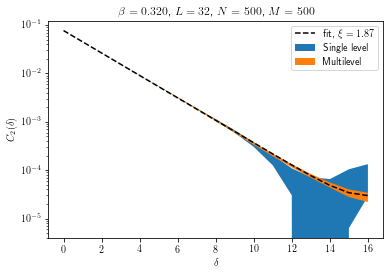

In [71]:
results = full_results[L]
beta_index = 20

single_means = numpy.mean(results[beta_index, 0], axis=1)
single_stds = numpy.std(results[beta_index, 0], axis=1)

multi_means = numpy.mean(results[beta_index, 1], axis=1)
multi_stds = numpy.std(results[beta_index, 1], axis=1)

deltas = numpy.arange(L // 2 + 1)

plt.fill_between(deltas, single_means - single_stds, single_means + single_stds,
                 label='Single level')
plt.fill_between(deltas, multi_means - multi_stds, multi_means + multi_stds,
                 label='Multilevel')

# Also plot the fit
xi = xis[L][beta_index]
A = As[L][beta_index]
beta = betas[beta_index]

fit_ys = A * (numpy.exp(-deltas / xi) + numpy.exp(-(L - deltas) / xi))

plt.plot(deltas, fit_ys, ls='--', color='k', label=rf'fit, $\xi={xi:.2f}$')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$C_2(\delta)$')
plt.title(rf'$\beta = {beta:.3f}$, $L={L}$, $N=500$, $M=500$')
plt.legend()
plt.yscale('log')
plt.savefig(f'{base_directory}graphs/two_point_correlator_example.pdf')

Let's see if the results agree within error

No handles with labels found to put in legend.


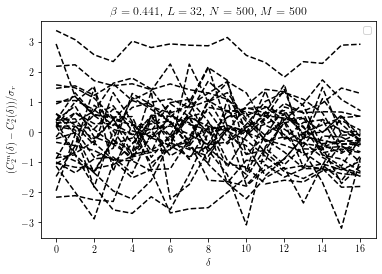

In [81]:
for beta_index, beta in enumerate(betas):
    single_means = numpy.mean(results[beta_index, 0], axis=1)
    single_stds = numpy.std(results[beta_index, 0], axis=1)

    multi_means = numpy.mean(results[beta_index, 1], axis=1)
    multi_stds = numpy.std(results[beta_index, 1], axis=1)

    # Add the errors in quaderature
    overall_stds = numpy.sqrt(multi_stds ** 2 + single_stds ** 2)

    deltas = numpy.arange(L // 2 + 1)

    ys = (multi_means - single_means) / overall_stds
    plt.plot(deltas, ys, ls='--', color='k')

    plt.xlabel(r'$\delta$')
    plt.ylabel(r'$(C_2^m(\delta) - C_2^s(\delta)) / \sigma_r(\delta)$')
    plt.title(rf'$\beta = {beta:.3f}$, $L={L}$, $N=500$, $M=500$')

plt.legend()
plt.savefig(f'{base_directory}graphs/pulls_graph.pdf')

Produce the plot given at the Lattice conference.

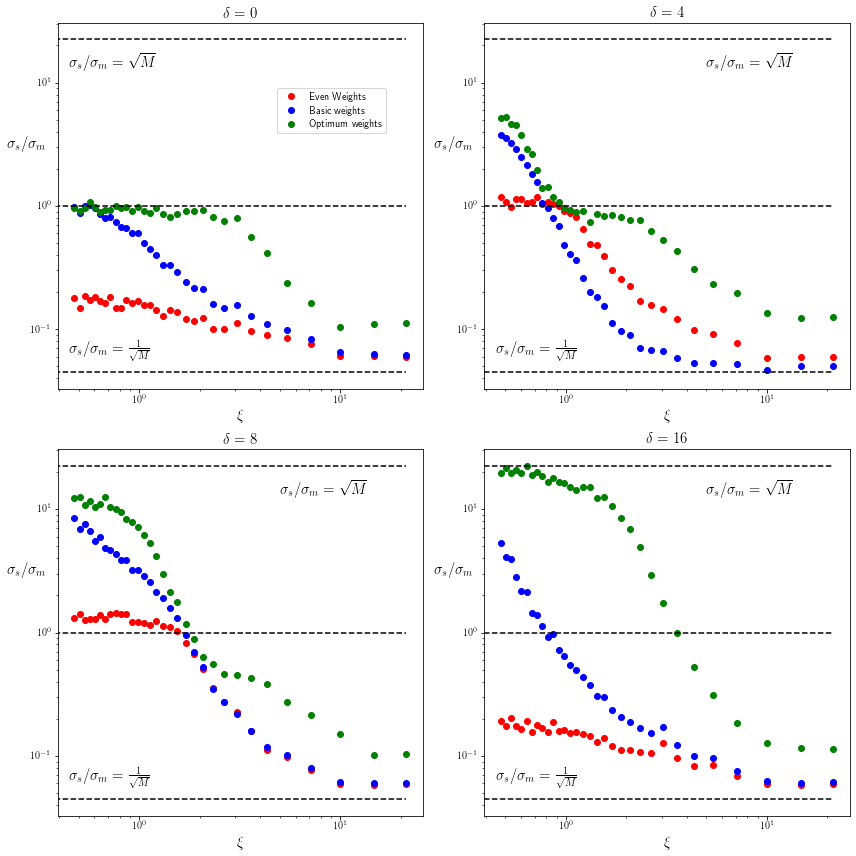

In [32]:
L = 32
results = full_results[L]
deltas = numpy.arange(L//2 + 1)

# Extract Standard deviations from the results
single_stds = numpy.std(results[:, 0], axis=2)
multi_stds = numpy.std(results[:, 1], axis=2)
multi_basic = numpy.std(results[:, 2], axis=2)
multi_unw = numpy.std(results[:, 3], axis=2)

delta_sample = [0, L // 8, L // 4, L // 2]
font_size = 15

fig, axes = plt.subplots(2, 2)

for i, delta in enumerate(delta_sample):  
    if len(numpy.array(axes).shape) == 1:
        ax = axes[i]

    else:
        dim_x, dim_y = numpy.array(axes).shape
        ax = axes[i // dim_y, i % dim_y]

    ax.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='Even Weights', color='r')
    ax.scatter(xis[L], (single_stds[:, delta] / multi_basic[:, delta])[:len(betas)], label='Basic weights', color='b')
    ax.scatter(xis[L], (single_stds[:, delta] / multi_stds[:, delta])[:len(betas)], label='Optimum weights', color='g')
    ax.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
    ax.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
    ax.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

    ax.set_title(rf"$\delta = {delta}$", fontsize=font_size)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(r'$ \sigma_s/\sigma_m$', rotation=0, fontsize=font_size, position=(0.5, 0.65))
    ax.set_xlabel(r"$\xi$", fontsize=font_size)

    if i == 0:
        ax.legend(loc=(0.6, 0.7))
        ax.text(0.45, 0.065, r' $ \sigma_s/\sigma_m = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
        ax.text(0.45, 13.5, r' $ \sigma_s/\sigma_m = \sqrt{M} $ ', fontsize=font_size)
    
    else:
        ax.text(0.45, 0.065, r' $ \sigma_s/\sigma_m = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
        ax.text(5, 13.5, r' $ \sigma_s/\sigma_m = \sqrt{M} $ ', fontsize=font_size)

    fig.set_size_inches((12, 12))
    plt.tight_layout()

    directory = f"{base_directory}graphs/"

plt.savefig(f"{directory}multi_panel_plot.pdf")
plt.show()

I will go through some representative examples now. Firstly consider the $\delta = 0$ correlator. It is impossible for multilevel to offer any imporvements to the error of this correlator, as it doesn't connect two different subregions. Therefore, the best we can hope for from multilevel is to match single level. This is what we see below for small correlation length. As the correlation length increases sublattice configurations become more and more boundary dependent, and the $NM$ independent configurations reduce to just $M$ in the case of multilevel, causing it to perform up to $\frac{1}{\sqrt{M}}$ worse. 

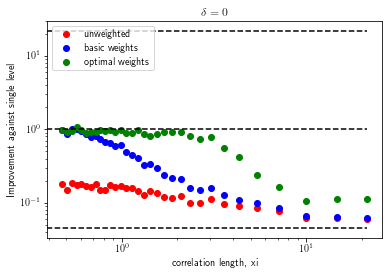

In [33]:
delta = 0

plt.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
plt.scatter(xis[L], (single_stds[:, delta] / multi_basic[:, delta])[:len(betas)], label='basic weights', color='b')
plt.scatter(xis[L], (single_stds[:, delta] / multi_stds[:, delta])[:len(betas)], label='optimal weights', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title(rf' $\delta = {delta} $ ')
plt.ylabel('Improvement against single level')
plt.xlabel('correlation length, xi')
plt.show()

Next we consider the best case scenario for multilevel, where the seperation between the points of the correlator is half the lattice size, $\delta = \left(\frac{L}{2}\right)$. This allows all but the boundary contributions to benefit from multievel as they connect the different subregions. At small correlation lengths, each sublattice configuration has little correlation to the boundary and so they are close to being independent. Therefore, a properly weighted multilevel achieves close the the optimum scaling improvement (by a factor of $\sqrt{M}$). The unweighted multilevel performs poorly across all correlation lengths, due to the fact that it weights the boundary contribution equally to all other contirubtions. This boundary contribution however has a standard deviation like $1/ \sqrt{N}$, as opposed to the non-boundary contributions, which scale like $1 / NM^2$. It therefore dominates the error. The basic weighting scheme fixes this issue, and performs reasonably at very small correaltion lengths. However, as the correaltion length increaes, the sub-lattice sites either side of the boundary become significantly correlated to the boundary, and so aren't independent from sub-lattice sample to sub-lattice sample. Therefore, the perfomance of this weighting scheme quickly deteriorates as the correlation length increases.

Text(0.5, 0, 'correlation length, xi')

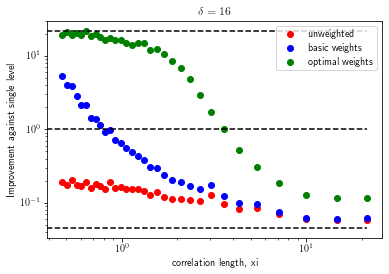

In [34]:
delta = L // 2

plt.scatter(xis[L], (single_stds[:, delta] / multi_unw[:, delta])[:len(betas)], label='unweighted', color='r')
plt.scatter(xis[L], (single_stds[:, delta] / multi_basic[:, delta])[:len(betas)], label='basic weights', color='b')
plt.scatter(xis[L], (single_stds[:, delta] / multi_stds[:, delta])[:len(betas)], label='optimal weights', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title(rf' $ \delta = {delta} $ ')
plt.ylabel('Improvement against single level')
plt.xlabel('correlation length, xi')

Intitively we may think that the absolute value of the correlation length isn't important, only its size relative to $L$. We will now test this intuition by looking at $L = 16$ and $L = 32$ data. To be explicit the hypothesis here is that as we send $L \xrightarrow[]{} \alpha L, \delta \xrightarrow[]{} \alpha \delta, \xi \xrightarrow[]{} \alpha \xi$, then the relative performance of multilevel stays about the same.

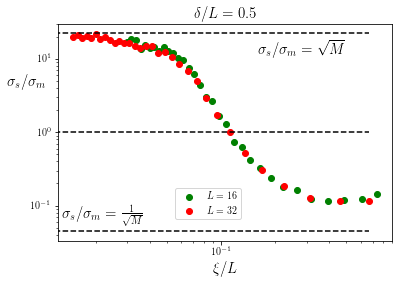

In [35]:
delta_frac = 1 / 2 # delta / L
L_s = [L // 2, L]
colors = {L // 2: 'g', L: 'r'}
font_size = 15

for L in L_s:
    results = full_results[L]

    # Extract Standard deviations from the results
    single_stds = numpy.std(results[:, 0], axis=2)
    multi_stds = numpy.std(results[:, 1], axis=2)

    delta = int(numpy.rint(delta_frac * L))

    plt.scatter(xis[L] / L, single_stds[:, delta] / multi_stds[:, delta], label=rf' $ L={L} $ ', color=colors[L])

plt.plot([0, max(xis[L] / L)], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L] / L)], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L] / L)], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$ \xi / L $', fontsize=font_size)

ylabel = plt.ylabel(r'$ \sigma_{s}/\sigma_{m} $', fontsize=font_size, position=(0.3, 0.7))
ylabel.set_rotation('0')

plt.text(0.013, 0.07, r' $ \sigma_{s}/\sigma_{m} = \frac{1}{\sqrt{M}} $ ', fontsize=font_size)
plt.text(0.16, 12, r' $ \sigma_{s}/\sigma_{m} = \sqrt{M} $ ', fontsize=font_size)

plt.title(rf'$ \delta / L = {delta_frac} $', fontsize=font_size)
plt.legend(loc=(0.35, 0.1))

plt.savefig(f'{base_directory}/graphs/scaling.pdf')
plt.show()
plt.close()

This is great, it feels like we're really beginning to understand multilevel performance here. Prehaps we can predict it without running a single simulation! That is the topic of the next section.

# 3. Theoretical Model
I will now go through a model for multilevel performance, which makes the following assumptions:

1. Time-slices are random variables correlated to eachother
2. Correlation between time-slices given by twopt function - e.g. $\langle S(t) S(t + \delta) \rangle = Ae^{\frac{-\delta}{\xi}}$.
3. Time-slices in different sub-regions only correlated indirectly via the boundary

This model is conceptually simple, but there is a fair amount of complexity involved in making sure that fields are correlated to eachother by the right amount. This is because the correlation matrix we looked at previously is the result of upto 6 different slice variables: two for each two-point function, and two from the two boundaries.

## 3.1 Normality of Slice Coordinates

In what is to follow we will treat the slice coordinate variables as normally distributed. This assumption is made due to the central limit theorum as they are an average over $L$ configurations. The larger the lattice size (and also the higher the dimensionality of the lattice) the better this approximation will hold. We can see by the plot we obtain that this is roughly the case in the symmetric phase but falls apart in the broken phase.

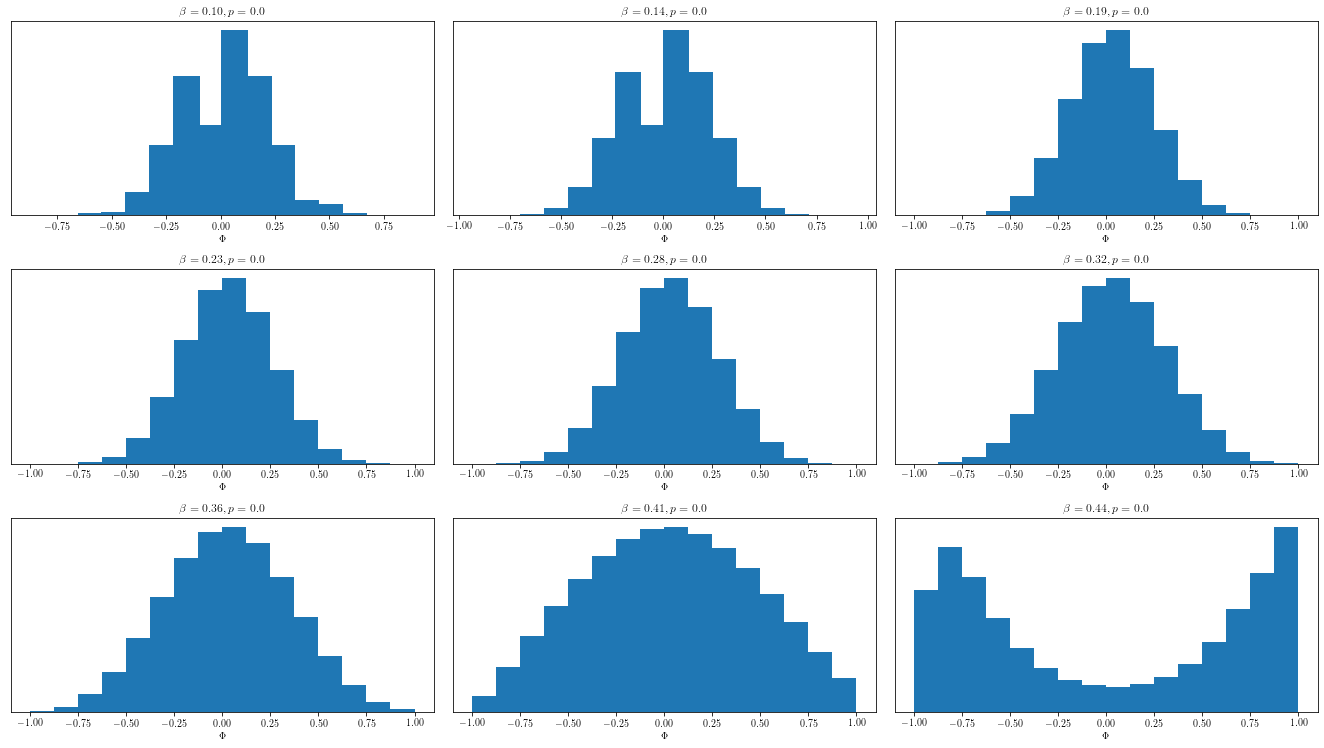

In [41]:
from scipy.stats import shapiro

N = 500
M = 500
step = 20

slice_data = numpy.zeros((no_betas, N * M * L))

for i, beta in enumerate(betas):
    data = single_slice_ising(L, beta, N * M, step)
    slice_data[i] = data.spin_slice.reshape(N * M * L)

nc = 3
nr = 3
fig, axes = plt.subplots(nr, nc)

# Use beta values from the previously calculated results
beta_nos = [x for x in range(0, L, 4)] + [-1]

for i, beta_no in enumerate(beta_nos):
    data = slice_data[beta_no]
    a, b = numpy.histogram(data, int(L / 2))
    axes[i // nc, i % nc].bar(b[:-1], a, width=4 / L, align='edge')
    axes[i // nc, i % nc].title.set_text(rf'$\beta = {betas[beta_no]:.2f}$')
    axes[i // nc, i % nc].axes.get_yaxis().set_visible(False)
    axes[i // nc, i % nc].set_xlabel(r'$\Phi$')

fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.savefig("graphs/slice_coordinate_distros.png", dpi=500)
plt.show()

We now assert a functional form for the correlation between two slice coordinates. The following function is appropriate for the Ising model in the symmetric phase, and also takes account of around the world effects with the $L- x$ term.

In [35]:
def correlation(delta, xi, L):
    """
        This function returns the expected correlation coefficient between slice-coordinate fields
        seperated by a distance of delta in the symmetric phase of the Ising model

        INPUTS:
        -------
        delta: int, seperation between slice-coordinate fields

        xi: float, the correlation length of the system

        L: int, sidelength of the lattice

        RETURNS:
        --------
        float with a value between 0 and 1
    """
    return numpy.exp(-delta / xi) + numpy.exp(-(L - delta) / xi) - numpy.exp(-L / xi)

## 3.2. Correlated field class

In [36]:
class fun_field(object):
    def __init__(self, name, dependents, correlations, x, N, M, region=0):
        """
            INPUTS:
            -------
            name: string, describes how this object is represented when printed.

            dependents: list of other fun_field instances, of which this field is dependent - e.g.
                part of the value of this field is determined from the correlation to these fields.

            correlations: vector of the same length and order as dependents containing the
                correlations between this field and each of the dependents - these values are
                between 0 and 1.

            N: int, number of boundary configurations

            M: int, number of sublattice configurations per boundary config

            x: int, position of the field slice variable on the lattice (starting at x = 0 for the
                first boundary)

            boundary: bool, True if this field insertion is in the boundary

            simulate: bool - if true then use numpy.random library to create correlated random
                variables, if it's false then use theoretical predictions to calculate variances

            region: int - the index of the region this field is contained within - see the
                region_maker function
        """
        self.region = region
        self.name = name
        self.dependents = dependents
        self.correlations = {}
        self.N = N
        self.M = M
        self.x = x

        # A field is absolutely correlated to itself
        self.correlations[self] = 1

        # Correlate this field with it's dependents and them with it
        for i, dependent in enumerate(dependents):
            self.correlations[dependent] = correlations[i]
            dependent.correlations[self] = correlations[i]
    
        # The coefficients of this fields random value from itself + its dependents (hence the + 1)
        self.coefficients = numpy.zeros(len(dependents) + 1)

        # If there are no dependents then this field is the result of a single random variable
        if len(dependents) == 0:
            self.coefficients = [1]
            self.noise_dict = Counter({self: 1})

        else:
            # Find the correlation matrix between contributions
            coefficient_matrix = numpy.zeros((len(dependents), len(dependents)))

            for i in range(len(dependents)):
                for k in range(len(dependents)):
                    coefficient_matrix[i, k] = dependents[i].correlations[dependents[k]]

            # The coefficients solve the equation C x = b, where C is the covariance matrix and b
            # is the correlation vector
            self.coefficients[:-1] = numpy.linalg.solve(coefficient_matrix, correlations)

            # We now use these coefficients to decompose the noise,
            # $X = \sum_i c_i Y_i$, with $Y_i ~ N(0, 1)$
            self.noise_dict = Counter({})
            for i, dependent in enumerate(dependents):
                c = self.coefficients[i]
                new_dict = {key: dependent.noise_dict[key] * c for key in dependent.noise_dict}
                self.noise_dict += new_dict

            # # The sum of the squares of the coefficients of the $N(0, 1)$ contributions should be
            # # 1, to give an overall variance of 1
            sum_squares = sum([self.noise_dict[entry] ** 2 for entry in self.noise_dict])
            self.coefficients[-1] = numpy.sqrt(1 - sum_squares)
            self.noise_dict += {self: self.coefficients[-1]}

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

We can now use this class representing a single field insertion to build up correlators of field insertions. To calculate the covariance matrix that we have used prevsiously we need four field insertions - two for each correlator, plus field insertions for the boundary layers. The two_correlators class is designed for this specific task.

The covariance between two two-point correlators is given by $Cov(C_2(x_1), C_2(x_2)) = \langle C(x_1) C(x_2) \rangle - \langle C(x_1) \rangle \langle C(x_2) \rangle = \langle \phi(x_1) \phi(x_1 + \delta) \phi(x_2) \phi(x_2 + \delta) \rangle - \left(\exp(-\frac{\delta}{\xi})\right)^2$.

In [37]:
def get_A(c_s, d_s, f_s, L):
    f_P, f_R, f_Q, f_S = f_s

    total = 0

    for x in range(L):
        for y in range(L):
            total += f_P[x] * f_Q[y] * f_R[x] * f_S[y]
            total += f_P[x] * f_Q[y] * f_R[y] * f_S[x]

    return total

def get_B(c_s, d_s, f_s, L):
    c_P, c_R, c_Q, c_S = c_s
    d_P, d_R, d_Q, d_S = d_s
    f_P, f_R, f_Q, f_S = f_s

    total = 0

    for x in range(L):
        for y in range(L):
            total += c_P[x] * c_Q[y] * c_R[x] * c_S[y]
            total += c_P[x] * c_Q[y] * c_R[y] * c_S[x]

            total += d_P[x] * d_Q[y] * d_R[x] * d_S[y]
            total += d_P[x] * d_Q[y] * d_R[y] * d_S[x]

            # Contribution from pairs of fields in a region and in the boundary for each correlator
            total += (c_P[x] * f_Q[y] + f_P[y] * c_Q[x]) * (c_R[x] * f_S[y] + f_R[y] * c_S[x])
            total += (d_P[x] * f_Q[y] + f_P[y] * d_Q[x]) * (d_R[x] * f_S[y] + f_R[y] * d_S[x])

    return total

def get_C(c_s, d_s, f_s, L):
    c_P, c_R, c_Q, c_S = c_s
    d_P, d_R, d_Q, d_S = d_s

    total = 0

    for x in range(L):
        for y in range(L):
            # Contribution from pairs of fields from different sub-regions
            total += (c_P[x] * d_Q[y] + d_P[y] * c_Q[x]) * (c_R[x] * d_S[y] + d_R[y] * c_S[x])

    return total

In [38]:
class two_correlators(object):
    """
        Extending correlator to take in 4 fields to give 2 correlators
    """
    def __init__(self, x1, x2, delta, xi, L, N, M, multi=True):
        """
            INPUTS:
            -------
            x1: int, location of first correlator
            x2: int, location of second correlator
            delta: int, seperation between points in each correlator
            xi: float, correlation length
            L: int, lattice size
            N: int, number of boundary configurations
            M: int, number of sublattice configurations
            multi: bool, calculate correlations assuming a multilevel simulation. If False then
                will assume N * M single level configurations
        """
        self.delta = delta
        self.L = L
        self.N = N
        self.M = M
        self.xi = xi
        self.multi = multi

        # Fields at x1, x2, x1 + delta and x2 + delta
        self.x_s = numpy.array([x1, x2, (x1 + delta) % L, (x2 + delta) % L])
        self.regions = numpy.where(self.x_s >= L // 2, 2, 1)
        self.fields = [None, None, None, None]

        if multi:
            # Add the boundaries: first boundary is uncorrelated, second is correlated to the first
            self.boundary1 = fun_field("B1", [], [], 0, N, M)
            self.boundary2 = fun_field("B2", [self.boundary1], [correlation(L // 2, xi, L)],
                                       L // 2, N, M)

            # Points in each region are only correlated to the boundaries and fields within that
            # region. Dependence on the other subregions occurs via. correlation to the boundary.
            for region in [1, 2]:
                dependents = {0: self.boundary1, L // 2: self.boundary2}

                for i in numpy.argwhere(self.regions == region)[:, 0]:
                    x = self.x_s[i]

                    if x in dependents:
                        # This means we already have a field at this site, so just use that field
                        self.fields[i] = dependents[x]

                    else:
                        # Correlate the new field to the other fields we have in the system
                        correlations = [correlation(abs(x - j), xi, L) for j in dependents]

                        self.fields[i] = fun_field(f"phi{x}", list(dependents.values()),
                                                   correlations, x,N, M, region=region)

                        dependents[x] = self.fields[i]

        # If single level then there are no boundaries - correlate all fields together.
        else:
            dependents = {}
    
            for i in range(4):
                x = self.x_s[i]

                if x in dependents:
                    # This means we already have a field at this site, so just use that field
                    self.fields[i] = dependents[x]

                else:
                    # Correlate the new field to the other fields we have in the system
                    correlations = [correlation(abs(x - j), xi, L) for j in dependents]

                    self.fields[i] = fun_field(f"phi{x}", list(dependents.values()), correlations,
                                               x, N * M, 1)
            
                    dependents[x] = self.fields[i]

    def estimate_covariance(self):
        # One entry for each field in the correlator. Each field can decompose into contributions
        # from any site on the lattice in general (hence there being self.L such contributions).
        c_s = [numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L)]
        d_s = [numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L)]
        f_s = [numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L)]
        
        if not self.multi:
            f_s = [numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L), numpy.zeros(self.L)]

            for i in range(4):
                for field, value in self.fields[i].noise_dict.items():
                    f_s[i][field.x] = value

            A = get_A(c_s, d_s, f_s, self.L)

            return A

        else:
            for i in range(4):
                for field, value in self.fields[i].noise_dict.items():
                    if field.region == 1:
                        c_s[i][field.x] = value

                    elif field.region == 2:
                        d_s[i][field.x] = value

                    else:
                        f_s[i][field.x] = value

            A = get_A(c_s, d_s, f_s, self.L)
            B = get_B(c_s, d_s, f_s, self.L)
            C = get_C(c_s, d_s, f_s, self.L)

            return A + B / self.M + C / self.M ** 2

Since we can now calculate the individual components of correlation matrices, it is trivial to calculate the whole matrix by itereting over the components. We can do this using the theoretical model, or by sampling the normal distributions with the numpy.random module

In [39]:
def get_cov_matrix(xi, L, delta, N, M, multi=True):
    # Avoid a singular matrix if the correlator is exactly half the lattice size
    matrix_size = L // 2 if delta == L // 2 else L
    
    cov_matrix = numpy.zeros((matrix_size, matrix_size))

    for x1 in range(matrix_size):
        for x2 in range(matrix_size):
            A = two_correlators(x1, x2, delta, xi, L, N, M, multi=multi)

            cov_matrix[x1, x2] = A.estimate_covariance()

    return cov_matrix

We now have everything we need to calculate the best performance increase we can hope for from multilevel! This of course depends on the lattice size, the two-point seperation and the correlation length.

In [40]:
def gain(xi, L, delta, N, M):
    cov_single = get_cov_matrix(xi, L, delta, N, M, multi=False) / (N * M)
    cov_multi = get_cov_matrix(xi, L, delta, N, M) / N

    weights_single = numpy.ones_like(cov_single[0]) / cov_single[0].shape
    weights_multi = get_weights(cov_multi)

    var_single = numpy.dot(weights_single, numpy.dot(cov_single, weights_single))
    var_multi = numpy.dot(weights_multi, numpy.dot(cov_multi, weights_multi))

    return numpy.sqrt(var_single / var_multi)

# 4. Testing

To test whether our model works, we need to be able to calculate the correlation length in a system. To do this we will use a cosh fit.

In [41]:
delta = L // 2

# Use the results we calculated in the previous section
results = full_results[L]

# Extract Standard deviations from the results
single_stds = numpy.std(results[:, 0, delta], axis=1)
multi_stds = numpy.std(results[:, 1, delta], axis=1)
gains_observed = single_stds / multi_stds

gains = numpy.zeros_like(single_stds)

for i, beta in enumerate(betas):
    print(f"{beta}")

    try:
        gains[i] = gain(xis[L][i], L, delta, N, M)

    except FloatingPointError:
        gains[i] = numpy.nan

0.1
0.11098989656483134
0.12197979312966269
0.13296968969449402
0.14395958625932537
0.15494948282415671
0.16593937938898803
0.17692927595381938
0.1879191725186507
0.19890906908348205
0.2098989656483134
0.22088886221314474
0.23187875877797606
0.2428686553428074
0.25385855190763873
0.2648484484724701
0.2758383450373014
0.28682824160213277
0.2978181381669641
0.3088080347317954
0.3197979312966268
0.3307878278614581
0.34177772442628945
0.3527676209911208
0.3637575175559521
0.3747474141207835
0.3857373106856148
0.3967272072504462
0.4077171038152775
0.4187070003801088
0.4296968969449402
0.44068679350977147


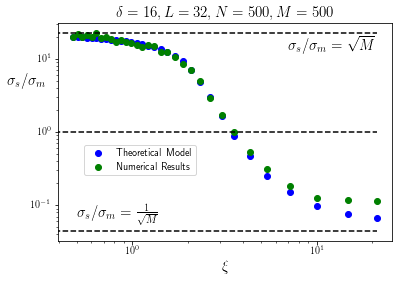

In [42]:
fontsize = 15

plt.scatter(xis[L], gains, label='Theoretical Model', color='b')
plt.scatter(xis[L], (single_stds / multi_stds)[:len(betas)], label='Numerical Results', color='g')
plt.plot([0, max(xis[L])], [1, 1], color='k', ls='--')
plt.plot([0, max(xis[L])], [numpy.sqrt(M), numpy.sqrt(M)], color='k', ls='--')
plt.plot([0, max(xis[L])], [1 / numpy.sqrt(M), 1 / numpy.sqrt(M)], color='k', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.title(rf' $ \delta = {delta}, L = {L}, N = {N}, M = {M} $ ', fontsize=fontsize)
plt.ylabel(r'$ \sigma_{s}/\sigma_{m} $', rotation=0, fontsize=fontsize, position=(0.3, 0.7))
plt.xlabel(r' $ \xi $', fontsize=fontsize)
plt.text(0.5, 0.07, r' $ \sigma_{s}/\sigma_{m} = \frac{1}{\sqrt{M}} $ ', fontsize=fontsize)
plt.text(7, 13, r' $ \sigma_{s}/\sigma_{m} = \sqrt{M} $ ', fontsize=fontsize)
plt.legend(loc=(0.08, 0.3))
plt.savefig(f'{base_directory}/graphs/theoretical_vs_observed.pdf')
plt.show()